In [1]:
!pip install tensorflow_addons

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow_addons as tfa

2023-01-07 07:37:39.474509: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-07 07:37:39.474592: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Data

In [3]:
df = pd.read_csv('/kaggle/input/tiki-books-dataset/comments.csv',
                 usecols = ['rating', 'content'])
df.head()

,rating,content
0,5,"Có những người bước đến, họ lấp đầy hạnh phúc ..."
1,5,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ..."
2,5,"Bìa cực xinh, tiki giao hàng nhanh, sách không..."
3,5,"Sách lúc nhận hình thức rất ổn, không cong vên..."
4,5,Một cuốn sách rất đáng đọc về tình yêu thương ...


# Data Preparation

In [4]:
print(f'Len of train dataset: {len(df)}')

Len of train dataset: 141281


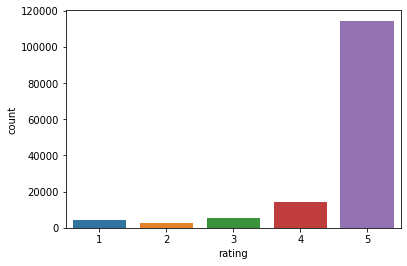

In [5]:
sns.countplot(x = df.rating);

### Missing Values

In [6]:
df.isna().sum()

rating         0
content    38018
dtype: int64

Let drop missing values!

In [7]:
df = df.dropna()

In [8]:
df.shape

(103263, 2)

### Split dataset

In [9]:
X = df.content.copy()
y = df.rating.copy()

### Target value

In [10]:
y = tf.keras.utils.to_categorical(y)

In [11]:
y.shape

(103263, 6)

### TPU setup

In [12]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy() 
    print('Number of replicas:', strategy.num_replicas_in_sync) 

2023-01-07 07:37:44.640650: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-07 07:37:44.641079: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-07 07:37:44.641106: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-07 07:37:44.641136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (44eb87f3ffbd): /proc/driver/nvidia/version does not exist
2023-01-07 07:37:44.641836: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [13]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,) 
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() 
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() 
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.0.0.2:8470']
Number of accelerators:  8


# Build Model

In [14]:
!pip3 install transformers

In [15]:
from transformers import TFAutoModel, AutoTokenizer

### Create Tokennizer

In [16]:
MAX_LEN = 200
model_name = 'vinai/phobert-base'

# Tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length', 
                    truncation = True, 
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X.items()]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.asarray(inputs), 
                                                    y,
                                                    random_state=1905, 
                                                    test_size=0.2, 
                                                    shuffle=True)

In [18]:
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [19]:
# Build model
with strategy.scope():
    encoder = TFAutoModel.from_pretrained(model_name)
    
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32)
    
    embedding = encoder(input_ids)[1]

    x = Dense(128, activation = 'relu', kernel_regularizer = regularizers.L2(0.1))(embedding)
    x = Dropout(0.2)(x)
    
    x = Dense(y.shape[1], 
              activation = 'softmax',
              kernel_initializer=tf.initializers.GlorotUniform(seed=1905),
              name='output_layer')(x)
    
    model = Model(inputs=[input_ids], outputs = x)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM TFBaseModelOutputWithPool 134998272 
_________________________________________________________________
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 6)                 774       
Total params: 135,097,478
Trainable params: 135,097,478
Non-trainable params: 0
_________________________________________________________________


In [21]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-3, 1e-4, 1e-5])

lr = 1e-2 * schedule(step)
wd = lambda: 1e-5 * schedule(step)

In [22]:
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])


In [23]:
# Train the model
history = model.fit(X_train,
                    y_train, 
                    epochs = 20,
                    verbose = 1, 
                    validation_split = 0.1,
                    batch_size = 256)

Epoch 1/20
291/291 [==============================] - 263s 411ms/step - loss: 22.2664 - accuracy: 0.7601 - val_loss: 20.3462 - val_accuracy: 0.7928
Epoch 2/20
291/291 [==============================] - 58s 199ms/step - loss: 19.8160 - accuracy: 0.8027 - val_loss: 18.2758 - val_accuracy: 0.8137
Epoch 3/20
291/291 [==============================] - 58s 199ms/step - loss: 17.8088 - accuracy: 0.8150 - val_loss: 16.4349 - val_accuracy: 0.8188
Epoch 4/20
291/291 [==============================] - 58s 200ms/step - loss: 15.9958 - accuracy: 0.8243 - val_loss: 14.7586 - val_accuracy: 0.8181
Epoch 5/20
291/291 [==============================] - 59s 203ms/step - loss: 14.3566 - accuracy: 0.8286 - val_loss: 13.2329 - val_accuracy: 0.8238
Epoch 6/20
291/291 [==============================] - 58s 200ms/step - loss: 12.8445 - accuracy: 0.8389 - val_loss: 11.8457 - val_accuracy: 0.8268
Epoch 7/20
291/291 [==============================] - 58s 200ms/step - loss: 11.4833 - accuracy: 0.8442 - val_loss: 1

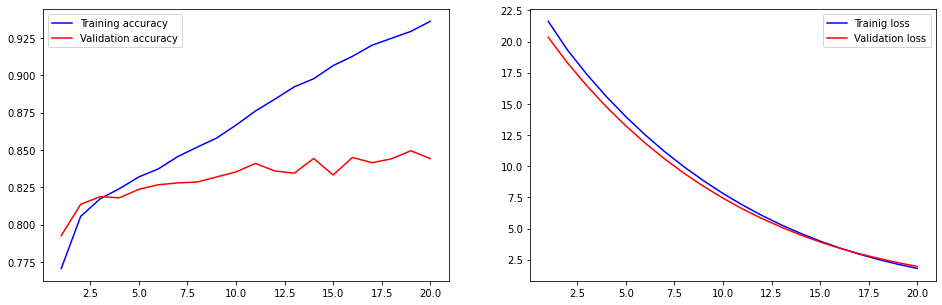

In [24]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

plt.show()

In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
81/81 [==============================] - 11s 128ms/step - loss: 1.9325 - accuracy: 0.8509
test loss, test acc: [1.9325358867645264, 0.8509175181388855]
